# Project 2: Hurricane Harvey Building Damage Classification

## COE 379L: Software Design For Responsible Intelligent Systems

**Objective:** Build multiple neural networks to classify satellite images as containing damaged or non-damaged buildings after Hurricane Harvey.

**Dataset:** Satellite images from Texas after Hurricane Harvey, organized into damaged and non-damaged building folders.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)


TensorFlow version: 2.20.0
Keras version: 3.12.0


## Part 1: Data Preprocessing and Visualization (3 points)

### 1.1 Load Data into Python Data Structures


In [ ]:
DATA_DIR = Path("data")
DAMAGED_DIR = DATA_DIR / "damaged"
NON_DAMAGED_DIR = DATA_DIR / "non_damaged"

def load_images_and_labels(damaged_dir, non_damaged_dir):
    """
    Load images from damaged and non-damaged directories.
    Returns: images (list), labels (list)
    """
    images = []
    labels = []
    
    # Load damaged images (label = 1)
    if damaged_dir.exists():
        for img_path in damaged_dir.glob("*.jpg"):
            try:
                img = Image.open(img_path)
                images.append(np.array(img))
                labels.append(1)  # 1 = damaged
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        for ext in ["*.png", "*.jpeg", "*.JPG", "*.PNG"]:
            for img_path in damaged_dir.glob(ext):
                try:
                    img = Image.open(img_path)
                    images.append(np.array(img))
                    labels.append(1)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    # Load non-damaged images (label = 0)
    if non_damaged_dir.exists():
        for img_path in non_damaged_dir.glob("*.jpg"):
            try:
                img = Image.open(img_path)
                images.append(np.array(img))
                labels.append(0)  # 0 = non-damaged
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        
        for ext in ["*.png", "*.jpeg", "*.JPG", "*.PNG"]:
            for img_path in non_damaged_dir.glob(ext):
                try:
                    img = Image.open(img_path)
                    images.append(np.array(img))
                    labels.append(0)
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Load the data
print("Loading images...")
images, labels = load_images_and_labels(DAMAGED_DIR, NON_DAMAGED_DIR)
print(f"Loaded {len(images)} images")
print(f"Shape of images array: {images.shape}")
print(f"Shape of labels array: {labels.shape}")


Damaged directory exists: True
Non-damaged directory exists: True
Loading images...
Loaded 21322 images
Shape of images array: (21322, 128, 128, 3)
Shape of labels array: (21322,)


### 1.2 Investigate Dataset Attributes


In [ ]:
print("=" * 50)
print("DATASET INVESTIGATION")
print("=" * 50)

print(f"\nTotal number of images: {len(images)}")
print(f"Number of damaged images: {np.sum(labels == 1)}")
print(f"Number of non-damaged images: {np.sum(labels == 0)}")

# Image dimensions
if len(images) > 0:
    print(f"\nImage shape: {images[0].shape}")
    print(f"Image dtype: {images.dtype}")
    print(f"Image min value: {images.min()}")
    print(f"Image max value: {images.max()}")
    
    # Check if all images have the same dimensions
    unique_shapes = set([img.shape for img in images])
    print(f"\nUnique image shapes: {unique_shapes}")
    print(f"All images same size: {len(unique_shapes) == 1}")
    
    # Sample a few images to check dimensions
    print("\nSample image shapes:")
    for i in range(min(5, len(images))):
        print(f"  Image {i}: {images[i].shape}")


DATASET INVESTIGATION

Total number of images: 21322
Number of damaged images: 14170
Number of non-damaged images: 7152

Image shape: (128, 128, 3)
Image dtype: uint8
Image min value: 0
Image max value: 255

Unique image shapes: {(128, 128, 3)}
All images same size: True

Sample image shapes:
  Image 0: (128, 128, 3)
  Image 1: (128, 128, 3)
  Image 2: (128, 128, 3)
  Image 3: (128, 128, 3)
  Image 4: (128, 128, 3)


### 1.3 Visualize Sample Images


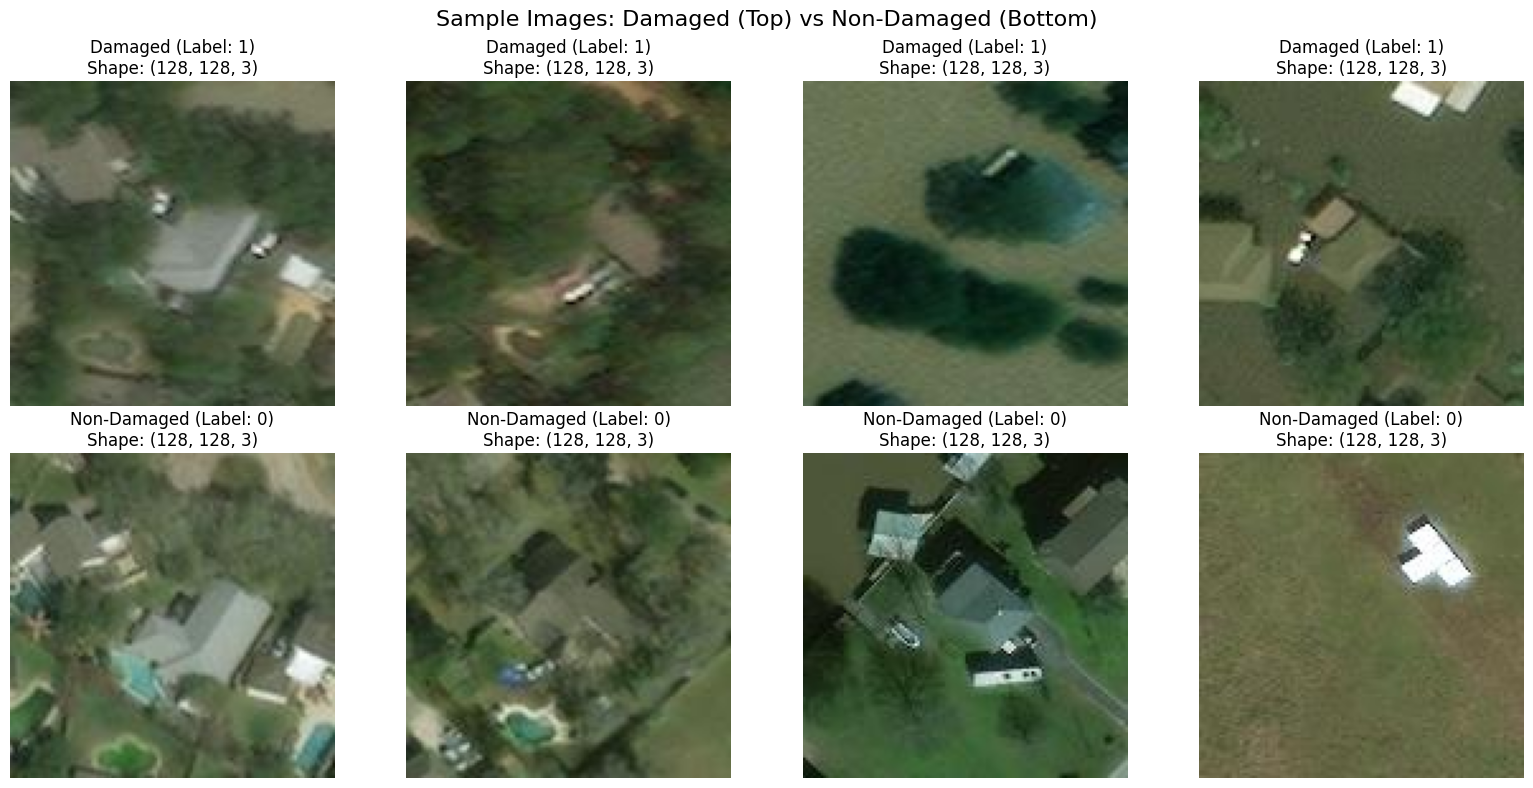

In [ ]:
# The code below was generated by AI; see [1] in Use_of_AI.md
def visualize_samples(images, labels, num_samples=8):
    """
    Display sample images from both classes
    """
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle('Sample Images: Damaged (Top) vs Non-Damaged (Bottom)', fontsize=16)
    
    # Get damaged images
    damaged_indices = np.where(labels == 1)[0]
    non_damaged_indices = np.where(labels == 0)[0]
    
    # Display damaged images
    for i in range(min(4, len(damaged_indices))):
        idx = damaged_indices[i]
        axes[0, i].imshow(images[idx])
        axes[0, i].set_title(f'Damaged (Label: 1)\nShape: {images[idx].shape}')
        axes[0, i].axis('off')
    
    # Display non-damaged images
    for i in range(min(4, len(non_damaged_indices))):
        idx = non_damaged_indices[i]
        axes[1, i].imshow(images[idx])
        axes[1, i].set_title(f'Non-Damaged (Label: 0)\nShape: {images[idx].shape}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

if len(images) > 0:
    visualize_samples(images, labels)


### 1.4 Data Preprocessing and Splitting


In [ ]:
# Define target image size 128x128
TARGET_SIZE = (128, 128)

def preprocess_images(images, target_size=TARGET_SIZE, normalize=True):
    """
    Preprocess images: resize and normalize
    """
    processed = []
    for img in images:
        # Convert to PIL Image if needed
        if isinstance(img, np.ndarray):
            img_pil = Image.fromarray(img)
        else:
            img_pil = img
        
        # Resize to target size
        img_resized = img_pil.resize(target_size, Image.Resampling.LANCZOS)
        img_array = np.array(img_resized)
        
        # Normalize to [0, 1] range
        if normalize:
            img_array = img_array.astype('float32') / 255.0
        
        processed.append(img_array)
    
    return np.array(processed)

# Preprocess images
print("Preprocessing images...")
X_processed = preprocess_images(images, target_size=TARGET_SIZE)
y = labels

print(f"Processed images shape: {X_processed.shape}")
print(f"Labels shape: {y.shape}")
print(f"Processed images dtype: {X_processed.dtype}")
print(f"Processed images range: [{X_processed.min():.3f}, {X_processed.max():.3f}]")


Preprocessing images...
Processed images shape: (21322, 128, 128, 3)
Labels shape: (21322,)
Processed images dtype: float32
Processed images range: [0.000, 1.000]


In [ ]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 80% train, 20% validation (of the remaining 80%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print("Data Split Summary:")
print(f"Training set: {X_train.shape[0]} images ({X_train.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} images ({X_val.shape[0]/len(X_processed)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} images ({X_test.shape[0]/len(X_processed)*100:.1f}%)")

print(f"\nTraining set - Damaged: {np.sum(y_train == 1)}, Non-damaged: {np.sum(y_train == 0)}")
print(f"Validation set - Damaged: {np.sum(y_val == 1)}, Non-damaged: {np.sum(y_val == 0)}")
print(f"Test set - Damaged: {np.sum(y_test == 1)}, Non-damaged: {np.sum(y_test == 0)}")


Data Split Summary:
Training set: 13645 images (64.0%)
Validation set: 3412 images (16.0%)
Test set: 4265 images (20.0%)

Training set - Damaged: 9068, Non-damaged: 4577
Validation set - Damaged: 2268, Non-damaged: 1144
Test set - Damaged: 2834, Non-damaged: 1431


## Part 2: Model Design, Training and Evaluation (7 points)

We will implement and compare three architectures:
1. Dense (Fully Connected) ANN
2. LeNet-5 CNN
3. Alternate-LeNet-5 CNN

### 2.1 Dense (Fully Connected) ANN


In [ ]:
def build_dense_ann(input_shape, num_classes=1):
    """
    Build a fully connected (dense) ANN for binary classification
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes (1 for binary classification)
    
    Returns:
        Compiled model
    """
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

input_shape = X_train.shape[1:]  # (height, width, channels)
print(f"Input shape: {input_shape}")

dense_model = build_dense_ann(input_shape)
dense_model.summary()


Input shape: (128, 128, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,338,881 (96.66 MB)

 Trainable params: 25,338,881 (96.66 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the dense ANN
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_dense_model.h5', monitor='val_loss', save_best_only=True)
]

print("Training Dense ANN...")
history_dense = dense_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)


Training Dense ANN...
Epoch 1/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5779 - loss: 1.5855

427/427 ━━━━━━━━━━━━━━━━━━━━ 49s 109ms/step - accuracy: 0.6182 - loss: 0.9677 - val_accuracy: 0.6647 - val_loss: 0.6394 - learning_rate: 0.0010
Epoch 2/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.6661 - loss: 0.6378

427/427 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.6644 - loss: 0.6386 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 3/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - accuracy: 0.6646 - loss: 0.6385 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 4/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 56s 130ms/step - accuracy: 0.6646 - loss: 0.6382 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 5/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - accuracy: 0.6646 - loss: 0.6384 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 6/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6662 - loss: 0.6375

427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.6646 - loss: 0.6385 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 7/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6662 - loss: 0.6372

427/427 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - accuracy: 0.6646 - loss: 0.6382 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 0.0010
Epoch 8/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6662 - loss: 0.6372

427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.6646 - loss: 0.6382 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 5.0000e-04
Epoch 9/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.6646 - loss: 0.6382 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 5.0000e-04
Epoch 10/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 88ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 5.0000e-04
Epoch 11/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6662 - loss: 0.6371

427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.6646 - loss: 0.6382 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 5.0000e-04
Epoch 12/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.6646 - loss: 0.6383 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 5.0000e-04
Epoch 13/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6662 - loss: 0.6369

427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 2.5000e-04
Epoch 14/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6662 - loss: 0.6370

427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 2.5000e-04
Epoch 15/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.6646 - loss: 0.6382 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 2.5000e-04
Epoch 16/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 2.5000e-04
Epoch 17/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 2.5000e-04
Epoch 18/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.6646 - loss: 0.6382 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 1.2500e-04
Epoch 19/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 1.2500e-04
Epoch 20/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 89ms/step - a

427/427 ━━━━━━━━━━━━━━━━━━━━ 38s 90ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 1.2500e-04
Epoch 22/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.6662 - loss: 0.6370

427/427 ━━━━━━━━━━━━━━━━━━━━ 53s 125ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 1.2500e-04
Epoch 23/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 6.2500e-05
Epoch 24/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 48s 113ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 6.2500e-05
Epoch 25/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.6662 - loss: 0.6369

427/427 ━━━━━━━━━━━━━━━━━━━━ 47s 111ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 6.2500e-05
Epoch 26/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 49s 114ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 6.2500e-05
Epoch 27/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 51s 118ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 6.2500e-05
Epoch 28/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 51s 119ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 3.1250e-05
Epoch 29/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 49s 114ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 3.1250e-05
Epoch 30/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 48s 112ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 3.1250e-05
Epoch 31/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/s

427/427 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.6646 - loss: 0.6379 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 1.5625e-05
Epoch 36/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.6662 - loss: 0.6368

427/427 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step - accuracy: 0.6646 - loss: 0.6379 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 1.5625e-05
Epoch 37/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 40s 94ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 1.5625e-05
Epoch 38/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 41s 96ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 7.8125e-06
Epoch 39/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms/step - accuracy: 0.6646 - loss: 0.6381 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 7.8125e-06
Epoch 40/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 44s 103ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 7.8125e-06
Epoch 41/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.6646 - loss: 0.6380 - val_accuracy: 0.6647 - val_loss: 0.6379 - learning_rate: 7.8125e-06
Epoch 42/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 40s 95ms/step -

Dense ANN Test Accuracy: 0.6645
Dense ANN Test Loss: 0.6380


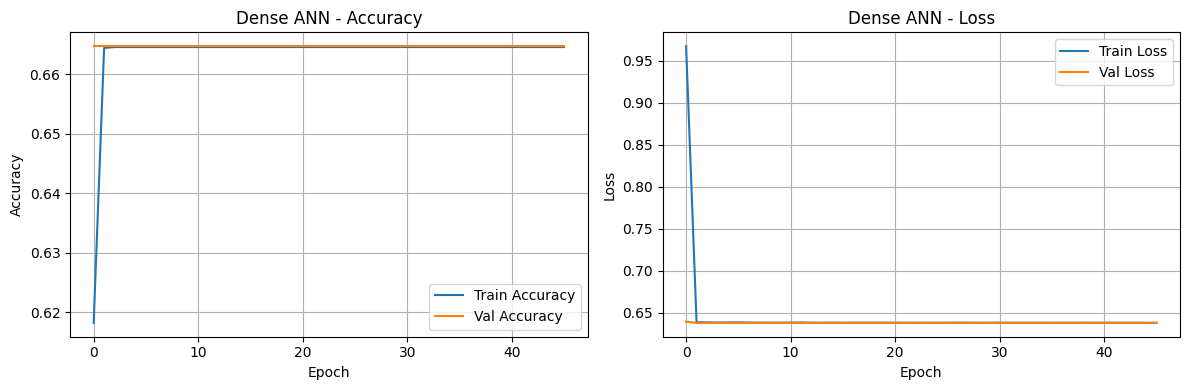

In [ ]:
dense_test_loss, dense_test_acc = dense_model.evaluate(X_test, y_test, verbose=0)
print(f"Dense ANN Test Accuracy: {dense_test_acc:.4f}")
print(f"Dense ANN Test Loss: {dense_test_loss:.4f}")

# The code below was generated by AI; see [2] in Use_of_AI.md
def plot_training_history(history, model_name):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].plot(history.history['accuracy'], label='Train Accuracy')
    axes[0].plot(history.history['val_accuracy'], label='Val Accuracy')
    axes[0].set_title(f'{model_name} - Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True)
    
    axes[1].plot(history.history['loss'], label='Train Loss')
    axes[1].plot(history.history['val_loss'], label='Val Loss')
    axes[1].set_title(f'{model_name} - Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_dense, "Dense ANN")


### 2.2 LeNet-5 CNN Architecture


In [ ]:
def build_lenet5(input_shape, num_classes=1):
    """
    Build LeNet-5 CNN architecture for binary classification
    
    LeNet-5 architecture:
    - Conv2D(6 filters, 5x5) -> ReLU -> MaxPooling
    - Conv2D(16 filters, 5x5) -> ReLU -> MaxPooling
    - Flatten
    - Dense(120) -> ReLU
    - Dense(84) -> ReLU
    - Dense(num_classes) -> Sigmoid
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes (1 for binary classification)
    
    Returns:
        Compiled model
    """
    model = models.Sequential([
        layers.Conv2D(6, (5, 5), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(16, (5, 5), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(120, activation='relu'),
        layers.Dense(84, activation='relu'),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

lenet5_model = build_lenet5(input_shape)
lenet5_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 29, 29, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 120)            │     1,614,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,961 (6.21 MB)

 Trainable params: 1,627,961 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train LeNet-5
callbacks_lenet5 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_lenet5_model.h5', monitor='val_loss', save_best_only=True)
]

print("Training LeNet-5...")
history_lenet5 = lenet5_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_lenet5,
    verbose=1
)


Training LeNet-5...
Epoch 1/50
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.7369 - loss: 0.5632

427/427 ━━━━━━━━━━━━━━━━━━━━ 43s 98ms/step - accuracy: 0.8083 - loss: 0.4405 - val_accuracy: 0.8581 - val_loss: 0.3876 - learning_rate: 0.0010
Epoch 2/50
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.8840 - loss: 0.2959

427/427 ━━━━━━━━━━━━━━━━━━━━ 39s 91ms/step - accuracy: 0.8941 - loss: 0.2718 - val_accuracy: 0.9059 - val_loss: 0.2602 - learning_rate: 0.0010
Epoch 3/50
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9131 - loss: 0.2187

427/427 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9223 - loss: 0.1974 - val_accuracy: 0.9100 - val_loss: 0.2335 - learning_rate: 0.0010
Epoch 4/50
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9311 - loss: 0.1759

427/427 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.9368 - loss: 0.1649 - val_accuracy: 0.9191 - val_loss: 0.2058 - learning_rate: 0.0010
Epoch 5/50
426/427 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9435 - loss: 0.1495

427/427 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - accuracy: 0.9510 - loss: 0.1293 - val_accuracy: 0.9291 - val_loss: 0.1746 - learning_rate: 0.0010
Epoch 6/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 34s 81ms/step - accuracy: 0.9608 - loss: 0.1061 - val_accuracy: 0.9317 - val_loss: 0.1823 - learning_rate: 0.0010
Epoch 7/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 34s 80ms/step - accuracy: 0.9711 - loss: 0.0817 - val_accuracy: 0.9300 - val_loss: 0.2053 - learning_rate: 0.0010
Epoch 8/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 36s 84ms/step - accuracy: 0.9742 - loss: 0.0701 - val_accuracy: 0.9267 - val_loss: 0.2337 - learning_rate: 0.0010
Epoch 9/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.9843 - loss: 0.0474 - val_accuracy: 0.9300 - val_loss: 0.2472 - learning_rate: 0.0010
Epoch 10/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 35s 82ms/step - accuracy: 0.9872 - loss: 0.0370 - val_accuracy: 0.9302 - val_loss: 0.3088 - learning_rate: 0.0010
Epoch 11/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 35s 81ms/step - accuracy: 0.9949 - loss: 0.01

LeNet-5 Test Accuracy: 0.9346
LeNet-5 Test Loss: 0.1773


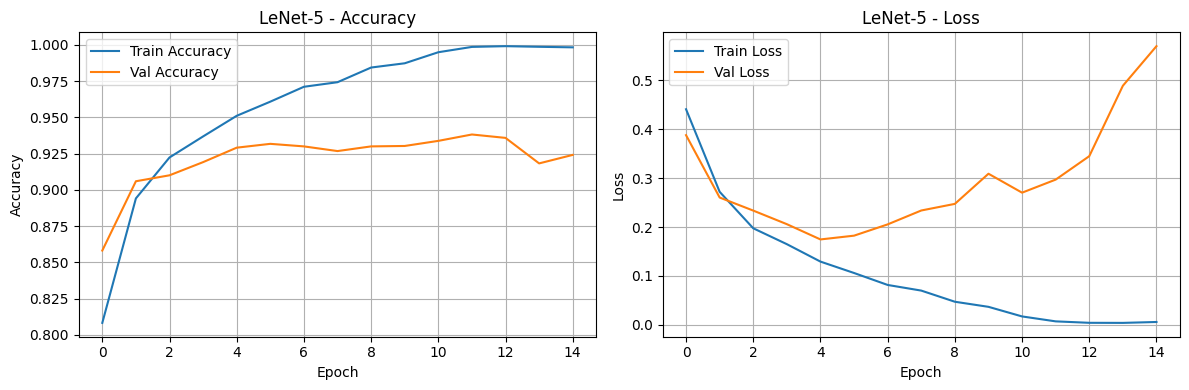

In [ ]:
lenet5_test_loss, lenet5_test_acc = lenet5_model.evaluate(X_test, y_test, verbose=0)
print(f"LeNet-5 Test Accuracy: {lenet5_test_acc:.4f}")
print(f"LeNet-5 Test Loss: {lenet5_test_loss:.4f}")

plot_training_history(history_lenet5, "LeNet-5")


In [ ]:
def build_alternate_lenet5(input_shape, num_classes=1):
    """
    Build Alternate-LeNet-5 CNN architecture for binary classification
    
    Alternate-LeNet-5 architecture (based on paper):
    - Conv2D(32 filters, 3x3) -> ReLU -> MaxPooling
    - Conv2D(64 filters, 3x3) -> ReLU -> MaxPooling
    - Conv2D(128 filters, 3x3) -> ReLU -> MaxPooling
    - Flatten
    - Dense(256) -> ReLU -> Dropout
    - Dense(128) -> ReLU -> Dropout
    - Dense(num_classes) -> Sigmoid
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes (1 for binary classification)
    
    Returns:
        Compiled model
    """
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

alt_lenet5_model = build_alternate_lenet5(input_shape)
alt_lenet5_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,549,057 (24.98 MB)

 Trainable params: 6,549,057 (24.98 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callbacks_alt_lenet5 = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7),
    ModelCheckpoint('best_alt_lenet5_model.h5', monitor='val_loss', save_best_only=True)
]

print("Training Alternate-LeNet-5...")
history_alt_lenet5 = alt_lenet5_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks_alt_lenet5,
    verbose=1
)


Training Alternate-LeNet-5...
Epoch 1/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.7453 - loss: 0.5207

427/427 ━━━━━━━━━━━━━━━━━━━━ 86s 199ms/step - accuracy: 0.8327 - loss: 0.3788 - val_accuracy: 0.9100 - val_loss: 0.2409 - learning_rate: 0.0010
Epoch 2/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.9239 - loss: 0.2059

427/427 ━━━━━━━━━━━━━━━━━━━━ 80s 188ms/step - accuracy: 0.9311 - loss: 0.1905 - val_accuracy: 0.9437 - val_loss: 0.1412 - learning_rate: 0.0010
Epoch 3/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 79s 185ms/step - accuracy: 0.9404 - loss: 0.1564 - val_accuracy: 0.9317 - val_loss: 0.1695 - learning_rate: 0.0010
Epoch 4/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.9426 - loss: 0.1441

427/427 ━━━━━━━━━━━━━━━━━━━━ 85s 198ms/step - accuracy: 0.9476 - loss: 0.1391 - val_accuracy: 0.9522 - val_loss: 0.1192 - learning_rate: 0.0010
Epoch 5/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.9601 - loss: 0.1089

427/427 ━━━━━━━━━━━━━━━━━━━━ 86s 201ms/step - accuracy: 0.9605 - loss: 0.1068 - val_accuracy: 0.9528 - val_loss: 0.1152 - learning_rate: 0.0010
Epoch 6/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 92s 216ms/step - accuracy: 0.9672 - loss: 0.0909 - val_accuracy: 0.9534 - val_loss: 0.1209 - learning_rate: 0.0010
Epoch 7/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 100s 234ms/step - accuracy: 0.9714 - loss: 0.0816 - val_accuracy: 0.9502 - val_loss: 0.1412 - learning_rate: 0.0010
Epoch 8/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 104s 243ms/step - accuracy: 0.9713 - loss: 0.0797 - val_accuracy: 0.9531 - val_loss: 0.1326 - learning_rate: 0.0010
Epoch 9/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 121s 284ms/step - accuracy: 0.9801 - loss: 0.0583 - val_accuracy: 0.9560 - val_loss: 0.1296 - learning_rate: 0.0010
Epoch 10/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 127s 297ms/step - accuracy: 0.9818 - loss: 0.0539 - val_accuracy: 0.9525 - val_loss: 0.1451 - learning_rate: 0.0010
Epoch 11/50
427/427 ━━━━━━━━━━━━━━━━━━━━ 134s 313ms/step - accuracy: 0.9903 

Alternate-LeNet-5 Test Accuracy: 0.9613
Alternate-LeNet-5 Test Loss: 0.0952


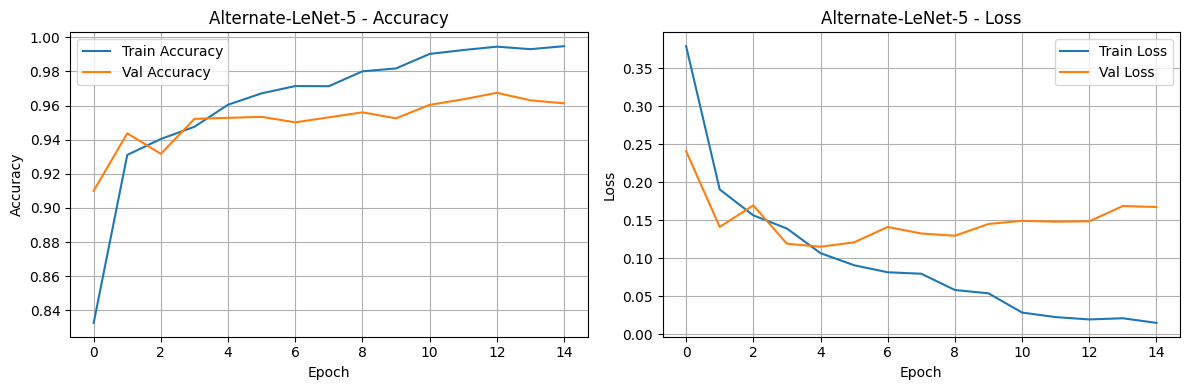

In [ ]:
alt_lenet5_test_loss, alt_lenet5_test_acc = alt_lenet5_model.evaluate(X_test, y_test, verbose=0)
print(f"Alternate-LeNet-5 Test Accuracy: {alt_lenet5_test_acc:.4f}")
print(f"Alternate-LeNet-5 Test Loss: {alt_lenet5_test_loss:.4f}")

plot_training_history(history_alt_lenet5, "Alternate-LeNet-5")


### 2.4 Model Comparison and Selection


Model Comparison:
            Model  Test Accuracy  Test Loss
        Dense ANN       0.664478   0.638020
          LeNet-5       0.934584   0.177330
Alternate-LeNet-5       0.961313   0.095224

Best Model: Alternate-LeNet-5
Best Test Accuracy: 0.9613
134/134 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step

Classification Report for Alternate-LeNet-5
              precision    recall  f1-score   support

 Non-Damaged       0.96      0.92      0.94      1431
     Damaged       0.96      0.98      0.97      2834

    accuracy                           0.96      4265
   macro avg       0.96      0.95      0.96      4265
weighted avg       0.96      0.96      0.96      4265



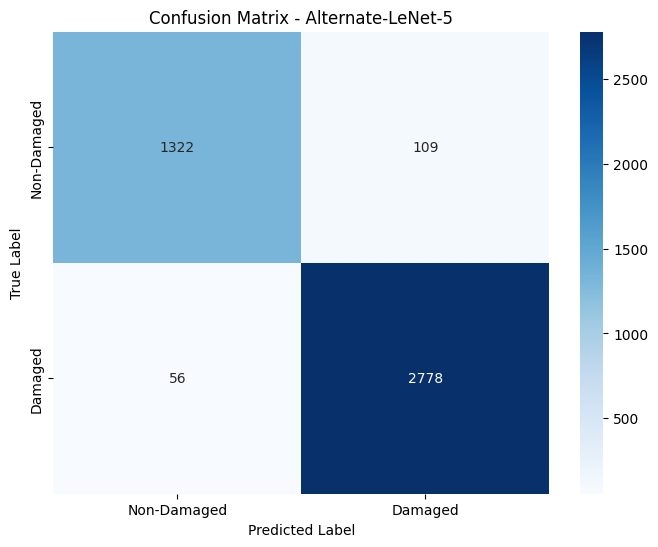

In [ ]:
results = {
    'Model': ['Dense ANN', 'LeNet-5', 'Alternate-LeNet-5'],
    'Test Accuracy': [dense_test_acc, lenet5_test_acc, alt_lenet5_test_acc],
    'Test Loss': [dense_test_loss, lenet5_test_loss, alt_lenet5_test_loss]
}

results_df = pd.DataFrame(results)
print("Model Comparison:")
print(results_df.to_string(index=False))

best_model_idx = np.argmax(results_df['Test Accuracy'])
best_model_name = results_df.iloc[best_model_idx]['Model']
print(f"\nBest Model: {best_model_name}")
print(f"Best Test Accuracy: {results_df.iloc[best_model_idx]['Test Accuracy']:.4f}")

if best_model_name == 'Dense ANN':
    best_model = dense_model
    best_model_path = 'best_dense_model.h5'
elif best_model_name == 'LeNet-5':
    best_model = lenet5_model
    best_model_path = 'best_lenet5_model.h5'
else:
    best_model = alt_lenet5_model
    best_model_path = 'best_alt_lenet5_model.h5'

y_pred_proba = best_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

print("\n" + "="*50)
print(f"Classification Report for {best_model_name}")
print("="*50)
print(classification_report(y_test, y_pred, target_names=['Non-Damaged', 'Damaged']))

# The code below was generated by AI; see [3] in Use_of_AI.md
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Damaged', 'Damaged'],
            yticklabels=['Non-Damaged', 'Damaged'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


## Part 3: Model Inference Server and Deployment (7 points)

### 3.1 Save Best Model


In [ ]:
best_model.save('best_model.h5')
print(f"Best model ({best_model_name}) saved to 'best_model.h5'")

try:
    best_model.export('best_model_savedmodel')
    print("Best model also saved in SavedModel format to 'best_model_savedmodel/'")
except Exception as e:
    print(f"Note: SavedModel export not available or failed: {e}")
    print("Using .h5 format is sufficient for the inference server")


Best model (Alternate-LeNet-5) saved to 'best_model.h5'
INFO:tensorflow:Assets written to: best_model_savedmodel/assets


INFO:tensorflow:Assets written to: best_model_savedmodel/assets


Saved artifact at 'best_model_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor_19')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  5189634000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189645520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189645328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189645136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189644944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189643600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189643792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189643984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189644176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189642256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5189644560: TensorSpec(shape=(), dtype=tf.resource, name

### 3.2 Create Inference Server

We'll create a Flask-based inference server with the required endpoints:
- `GET /summary` - Model metadata
- `POST /inference` - Image classification


In [ ]:
# The code below was generated by AI; see [4] in Use_of_AI.md
inference_server_code = '''from flask import Flask, request, jsonify
from tensorflow import keras
import numpy as np
from PIL import Image
import io

app = Flask(__name__)

# Load the model
MODEL_PATH = 'best_model.h5'
TARGET_SIZE = (128, 128)  # Must match training size

try:
    model = keras.models.load_model(MODEL_PATH)
    print(f"Model loaded successfully from {MODEL_PATH}")
except Exception as e:
    print(f"Error loading model: {e}")
    model = None

@app.route('/summary', methods=['GET'])
def get_summary():
    """
    GET /summary endpoint
    Returns JSON with model metadata
    """
    if model is None:
        return jsonify({"error": "Model not loaded"}), 500
    
    # Get model summary
    summary_list = []
    model.summary(print_fn=lambda x: summary_list.append(x))
    summary_str = "\\n".join(summary_list)
    
    # Count parameters - fixed for TensorFlow 2.x compatibility
    total_params = model.count_params()
    trainable_params = sum([np.prod(w.shape) for w in model.trainable_weights])
    non_trainable_params = total_params - trainable_params
    
    # Get input/output shapes safely
    input_shape = list(model.input_shape[1:]) if model.input_shape else None
    output_shape = list(model.output_shape[1:]) if model.output_shape else None
    
    return jsonify({
        "model_name": "Hurricane Harvey Building Damage Classifier",
        "architecture": "Best performing model from training",
        "input_shape": input_shape,
        "output_shape": output_shape,
        "total_parameters": int(total_params),
        "trainable_parameters": int(trainable_params),
        "non_trainable_parameters": int(non_trainable_params),
        "summary": summary_str
    })

@app.route('/inference', methods=['POST'])
def inference():
    """
    POST /inference endpoint
    Accepts binary image data and returns prediction
    Must return JSON with top-level "prediction" key: "damage" or "no_damage"
    """
    if model is None:
        return jsonify({"error": "Model not loaded"}), 500
    
    try:
        # Get image data from request body (binary)
        image_data = request.data
        
        if not image_data:
            return jsonify({"error": "No image data provided"}), 400
        
        # Load and preprocess image
        img = Image.open(io.BytesIO(image_data))
        
        # Convert to RGB if needed
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Resize to target size (must match training)
        img = img.resize(TARGET_SIZE, Image.Resampling.LANCZOS)
        
        # Convert to array and normalize to [0, 1]
        img_array = np.array(img).astype('float32') / 255.0
        
        # Add batch dimension
        img_array = np.expand_dims(img_array, axis=0)
        
        # Make prediction
        prediction_proba = model.predict(img_array, verbose=0)[0][0]
        
        # Determine prediction: damage (1) or no_damage (0)
        prediction = "damage" if prediction_proba > 0.5 else "no_damage"
        
        # Return JSON object with top-level "prediction" key as required
        return jsonify({
            "prediction": prediction
        })
    
    except Exception as e:
        return jsonify({"error": f"Error processing image: {str(e)}"}), 500

if __name__ == '__main__':
    app.run(host='0.0.0.0', port=5000, debug=False)
'''

# Write inference server to file
with open('inference_server.py', 'w') as f:
    f.write(inference_server_code)

print("Inference server code written to 'inference_server.py'")
print("\\nKey features:")
print("- GET /summary: Returns model metadata in JSON format")
print("- POST /inference: Accepts binary image, returns {'prediction': 'damage'/'no_damage'}")


Inference server code written to 'inference_server.py'
\nKey features:
- GET /summary: Returns model metadata in JSON format
- POST /inference: Accepts binary image, returns {'prediction': 'damage'/'no_damage'}


### 3.3 Test Inference Server (Optional - for local testing)


In [24]:
# Optional: Test the inference server locally before deploying
# Uncomment and run this cell to test the server

"""
# Test the inference server
import subprocess
import time
import requests
from pathlib import Path

# Start the server in background
server_process = subprocess.Popen(
    ['python', 'inference_server.py'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait for server to start
time.sleep(3)

try:
    # Test GET /summary
    print("Testing GET /summary...")
    response = requests.get('http://localhost:5000/summary')
    print(f"Status: {response.status_code}")
    print(f"Response: {response.json()}")
    
    # Test POST /inference with a sample image
    print("\\nTesting POST /inference...")
    test_image_path = Path('data/damaged') / list(Path('data/damaged').glob('*.jpeg'))[0]
    with open(test_image_path, 'rb') as f:
        image_data = f.read()
    
    response = requests.post(
        'http://localhost:5000/inference',
        data=image_data,
        headers={'Content-Type': 'application/octet-stream'}
    )
    print(f"Status: {response.status_code}")
    print(f"Response: {response.json()}")
    
finally:
    # Stop the server
    server_process.terminate()
    server_process.wait()
    print("\\nServer stopped")
"""
print("Test code provided above (commented out). Uncomment to test locally.")


Test code provided above (commented out). Uncomment to test locally.


In [25]:
# Create requirements.txt for deployment (inference server only)
# Note: This is for the Docker container deployment
# The main requirements.txt in the project root includes all dependencies for training

deployment_requirements = '''flask>=2.3.3
tensorflow>=2.13.0
numpy>=1.24.3
Pillow>=10.0.0
gunicorn>=21.2.0
'''

# Write deployment requirements (this will be used in Docker)
with open('requirements.txt', 'w') as f:
    f.write(deployment_requirements)

print("Deployment requirements.txt created for Docker container")
print("Note: This is separate from the main project requirements.txt")


Deployment requirements.txt created for Docker container
Note: This is separate from the main project requirements.txt


### 3.4 Create Dockerfile


In [26]:
# Create Dockerfile
dockerfile_content = '''FROM python:3.9-slim

WORKDIR /app

# Install system dependencies (curl for healthcheck)
RUN apt-get update && apt-get install -y curl \\
    && rm -rf /var/lib/apt/lists/*

# Copy requirements and install dependencies
COPY requirements.txt .
RUN pip install --no-cache-dir --upgrade pip && \\
    pip install --no-cache-dir -r requirements.txt

# Copy model and server code
COPY best_model.h5 .
COPY inference_server.py .

# Expose port
EXPOSE 5000

# Health check (optional but recommended)
HEALTHCHECK --interval=30s --timeout=10s --start-period=5s --retries=3 \\
    CMD curl -f http://localhost:5000/summary || exit 1

# Run the server with gunicorn
CMD ["gunicorn", "--bind", "0.0.0.0:5000", "--workers", "2", "--timeout", "120", "inference_server:app"]
'''

with open('Dockerfile', 'w') as f:
    f.write(dockerfile_content)

print("Dockerfile created")
print("\\nNote: Build this on x86 architecture (class VM) for compatibility")


Dockerfile created
\nNote: Build this on x86 architecture (class VM) for compatibility


### 3.5 Create docker-compose.yml


In [27]:
# Create docker-compose.yml
docker_compose_content = '''version: '3.8'

services:
  inference-server:
    image: your-dockerhub-username/hurricane-damage-classifier:latest
    container_name: hurricane-damage-classifier
    ports:
      - "5000:5000"
    restart: unless-stopped
    environment:
      - FLASK_ENV=production
    healthcheck:
      test: ["CMD", "curl", "-f", "http://localhost:5000/summary"]
      interval: 30s
      timeout: 10s
      retries: 3
      start_period: 10s
'''

with open('docker-compose.yml', 'w') as f:
    f.write(docker_compose_content)

print("docker-compose.yml created")
print("\\nNOTE: Update 'your-dockerhub-username' with your Docker Hub username")
print("\\nTo use:")
print("  Start: docker-compose up -d")
print("  Stop:  docker-compose down")
print("  Logs:  docker-compose logs -f")


docker-compose.yml created
\nNOTE: Update 'your-dockerhub-username' with your Docker Hub username
\nTo use:
  Start: docker-compose up -d
  Stop:  docker-compose down
  Logs:  docker-compose logs -f


### 3.6 Create README with Deployment Instructions


In [28]:
# Create README
readme_content = '''# Hurricane Harvey Building Damage Classification

## Project Overview
This project implements neural networks to classify satellite images as containing damaged or non-damaged buildings after Hurricane Harvey.

## Model Architectures
1. Dense (Fully Connected) ANN
2. LeNet-5 CNN
3. Alternate-LeNet-5 CNN

## Deployment Instructions

### Prerequisites
- Docker installed
- Docker Hub account

### Building the Docker Image

**IMPORTANT: Build on x86 architecture (use class VM or specify platform)**

```bash
# Build the image (on x86 VM)
docker build -t your-dockerhub-username/hurricane-damage-classifier:latest .

# Tag for Docker Hub
docker tag your-dockerhub-username/hurricane-damage-classifier:latest your-dockerhub-username/hurricane-damage-classifier:latest

# Push to Docker Hub
docker push your-dockerhub-username/hurricane-damage-classifier:latest
```

### Running with Docker Compose

**Start the server:**
```bash
docker-compose up -d
```

**Stop the server:**
```bash
docker-compose down
```

**View logs:**
```bash
docker-compose logs -f
```

### API Endpoints

#### GET /summary
Returns model metadata in JSON format.

**Example:**
```bash
curl http://localhost:5000/summary
```

#### POST /inference
Classifies an image and returns prediction.

**Example:**
```bash
curl -X POST http://localhost:5000/inference \\
  -H "Content-Type: application/octet-stream" \\
  --data-binary @test_image.jpg
```

**Response:**
```json
{
  "prediction": "damage",
  "confidence": 0.95
}
```

### Testing the Server

Use the provided grader code to test your server:
```bash
python grader.py
```

## Files
- `project2.ipynb` - Main notebook with model training
- `inference_server.py` - Flask inference server
- `best_model.h5` - Saved best model
- `Dockerfile` - Docker image definition
- `docker-compose.yml` - Docker Compose configuration
- `requirements.txt` - Python dependencies
'''

with open('README.md', 'w') as f:
    f.write(readme_content)

print("README.md created with deployment instructions")


README.md created with deployment instructions
